In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/2021/Finger-Print Classification')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
def data_info(direct):
  files = [file.strip() for file in os.listdir('./data/'+direct)]  # 디렉토리 안에 있는 이미지들의 이름
  filenames = []     
  for file in files:            # 파일명, 클래스 분류
    add = [file[:-4],file[0]]   # 파일명과 인덱스(파일명의 첫 번째 값) 반환
    filenames.append(add)
  return filenames

In [ ]:
df_train = data_info(direct = 'train')
df_test = data_info(direct = 'test_1')

# 데이터프레임 생성
train = pd.DataFrame(df_train, columns =['filename', 'label']) 
test = pd.DataFrame(df_test, columns = ['filename', 'label'])   # test data에서 label 값 의미 없는 값(실제 라벨 값 아님) -> predict 후 바꿔줄것
display(train.head(), test.head())

NameError: ignored

In [ ]:
print('train:', len(train))
print('test:', len(test))

train: 80
test: 2


In [ ]:
def pixel_info(direct, df):
  pixels = []
  for file in list(df['filename']):  # 각 이미지에 대해
    from PIL import Image
    im = Image.open('./data/'+direct+'/'+file+'.bmp')  # 이미지 불러오기
    pix = list(im.getdata())   # 각 이미지 픽셀값 계산
    pixels.append(pix)

  df_pix = pd.DataFrame(pixels, columns = list(range(144**2)))  # pixel data 담은 dataframe
  return df_pix

In [ ]:
train_pix = pixel_info('train', train)
test_pix = pixel_info('test', test)

TypeError: ignored

In [ ]:
display(train_pix.head(), test_pix.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20696,20697,20698,20699,20700,20701,20702,20703,20704,20705,20706,20707,20708,20709,20710,20711,20712,20713,20714,20715,20716,20717,20718,20719,20720,20721,20722,20723,20724,20725,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20696,20697,20698,20699,20700,20701,20702,20703,20704,20705,20706,20707,20708,20709,20710,20711,20712,20713,20714,20715,20716,20717,20718,20719,20720,20721,20722,20723,20724,20725,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


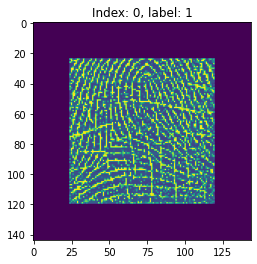

In [ ]:
idx = 0
img = train_pix.loc[idx, '0':].values.reshape(144, 144).astype(int)
label = train.loc[idx, 'label']

plt.title('Index: %i, label: %s'%(idx, label))
plt.imshow(img)
plt.show()

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(train_pix.values, train['label'], test_size = 0.3, random_state=42, shuffle=True, stratify=None)


In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

cb = CatBoostClassifier(n_estimators = 60, verbose = 20)
cb.fit(X_train, y_train)

     |████████████████████████████████| 69.2 MB 4.8 kB/s 
Learning rate set to 0.5
0:	learn: 1.5841341	total: 3.53s	remaining: 3m 28s
20:	learn: 0.0911243	total: 48.3s	remaining: 1m 29s
40:	learn: 0.0388636	total: 1m 31s	remaining: 42.3s
59:	learn: 0.0246293	total: 2m 10s	remaining: 0us


In [ ]:
scores = cross_val_score(cb, X_train, y_train, cv = 3, scoring = 'accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Learning rate set to 0.5
0:	learn: 1.7247782	total: 2.34s	remaining: 2m 17s
20:	learn: 0.1341635	total: 31.9s	remaining: 59.2s
40:	learn: 0.0532243	total: 1m 2s	remaining: 29s
59:	learn: 0.0329071	total: 1m 28s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.6660224	total: 2.45s	remaining: 2m 24s
20:	learn: 0.1370090	total: 35s	remaining: 1m 4s
40:	learn: 0.0524732	total: 1m 5s	remaining: 30.5s
59:	learn: 0.0326428	total: 1m 36s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.6724428	total: 2.31s	remaining: 2m 16s
20:	learn: 0.1218433	total: 33.4s	remaining: 1m 2s
40:	learn: 0.0503691	total: 1m 2s	remaining: 28.8s
59:	learn: 0.0317095	total: 1m 29s	remaining: 0us
Accuracy: 0.98 (+/- 0.05)


In [ ]:
with open('./model/model_cb.pkl','wb') as f:
    pickle.dump(cb,f)

In [ ]:
with open('model/model_cb.pkl', 'rb') as f:
    best = pickle.load(f)

In [ ]:
val_pred = best.predict(X_val)
pred = pd.DataFrame(val_pred)
pred = list(pred.iloc[:,0])

In [ ]:
val = list(y_val)

In [ ]:
print("Accuracy: %0.2f" % (accuracy_score(pred, val)))

Accuracy: 1.00


In [ ]:
print(classification_report(pred ,val))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [ ]:
test_pred = best.predict(test_pix.values)

In [ ]:
test['label'] = test_pred                            # 예측한 라벨 값 매핑
test['filename'] = pd.to_numeric(test["filename"])      # filename numeric하게 바꾸기
test                                                    # 예측한 라벨값과 매핑된 결과

,filename,label
0,10,3
1,2,2


In [ ]:
result = test.sort_values(by=['filename'], ascending=True)  # 파일 이름 순서대로 정렬
result.head()

,filename,label
1,2,2
0,10,3


In [ ]:
result['filename']

1     2
0    10
Name: filename, dtype: int64

In [ ]:
result['filename'][0]
result['label'][0]

'3'

In [ ]:
result['filename'][0]


10

In [ ]:
result['filename'][1]

2

In [ ]:
result['label'][0]

'3'

In [ ]:
result['label'][1]

'2'

In [ ]:
print(result['label'][1])

2
